In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data

In [2]:
# Descargar datos históricos para Apple (AAPL)
ticker = 'NVDA'
data = yf.download(ticker, start='2021-01-01', end='2024-10-13')

# Preparación de la serie temporal
df = data[['Open', 'Close', 'Low', 'High', 'Volume']]
df

[*********************100%%**********************]  1 of 1 completed


,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


In [3]:
closeData = df.Close.values.astype('float32')

total_rows = closeData.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

XTrain = closeData[:train_end]
XValidation = closeData[train_end:validation_end]
XTest = closeData[validation_end:]

print("Training set size:", len(XTrain), f"({len(XTrain)/len(closeData)*100}%)")
print("Validation set size:", len(XValidation), f"({len(XValidation)/len(closeData)*100}%)")
print("Test set size:", len(XTest), f"({len(XTest)/len(closeData)*100}%)")

Training set size: 665 (70.0%)
Validation set size: 190 (20.0%)
Test set size: 95 (10.0%)


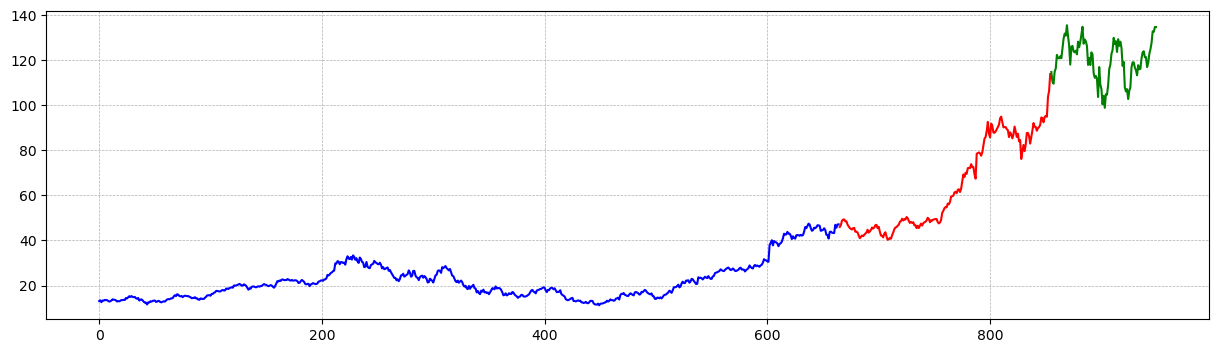

In [4]:
plt.figure(figsize=(15,4))

# plt.plot(openData, color='gray')
plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show() 

## Processing data

In [5]:
closeData.shape

(950,)

In [6]:
closeData = closeData.reshape(-1,1)
XTrain = XTrain.reshape(-1,1)
XValidation = XValidation.reshape(-1,1)
XTest = XTest.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(closeData)

openData = scaler.transform(closeData)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)

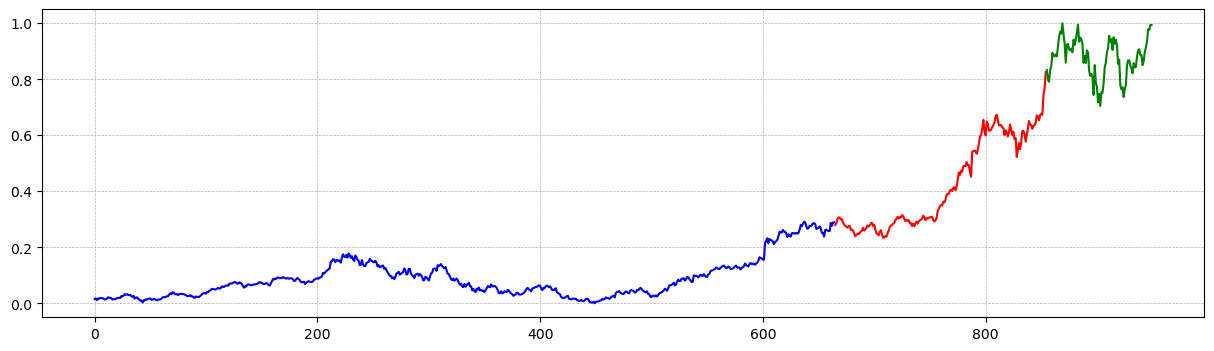

In [7]:
plt.figure(figsize=(15,4))

plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [8]:
def create_lookback(dataset, lookback, device):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        after_window = dataset[i + lookback]
        X.append(window)
        y.append(after_window)
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    return X_tensor, y_tensor

In [9]:
# Dispositivo para entrenamiento (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
lookback = 2
XTrain_tensor, TTrain_tensor = create_lookback(XTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback(XValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback(XTest, lookback, device)

Timeseries_tensor, TTimeseries_tensor = create_lookback(openData, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([663, 2, 1]), 
TTrain_tensor shape: torch.Size([663, 1])

XValidation_tensor shape: torch.Size([188, 2, 1]), 
TValidation_tensor shape: torch.Size([188, 1])

XTest_tensor shape: torch.Size([93, 2, 1]), 
TTest_tensor shape: torch.Size([93, 1])


In [11]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

21
6
3


## LSTM Model

In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

#### Training and Validation

Epoch [5/50] - Training Loss: 0.0045, Validation Loss: 0.1223, Learning Rate: 0.000500
Validation RMSE: 42.952248


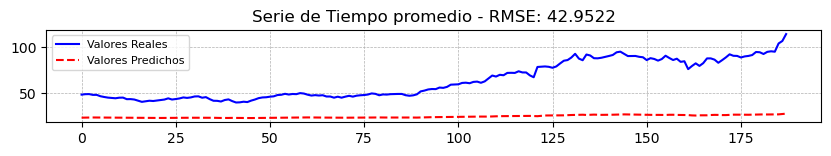


Epoch [10/50] - Training Loss: 0.0038, Validation Loss: 0.1032, Learning Rate: 0.000500
Validation RMSE: 39.464325


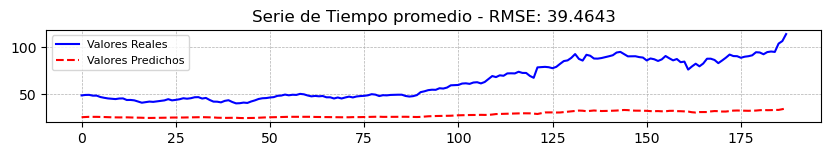


Epoch [15/50] - Training Loss: 0.0028, Validation Loss: 0.0616, Learning Rate: 0.000500
Validation RMSE: 30.48563


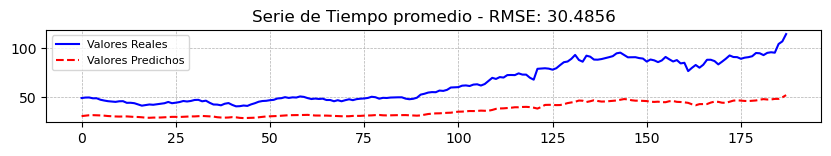


Epoch [20/50] - Training Loss: 0.0011, Validation Loss: 0.0103, Learning Rate: 0.000500
Validation RMSE: 12.508728


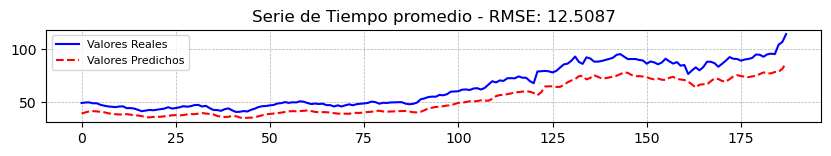


Epoch [25/50] - Training Loss: 0.0004, Validation Loss: 0.0009, Learning Rate: 0.000500
Validation RMSE: 3.6395447


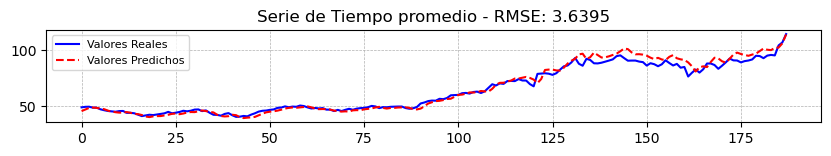


Epoch [30/50] - Training Loss: 0.0003, Validation Loss: 0.0013, Learning Rate: 0.000500
Validation RMSE: 4.401707


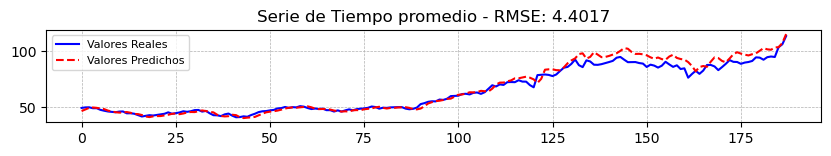


Early stopping! in epoch 34
Training Loss: 0.0003, Validation Loss: 0.0014, Learning Rate: 0.000500
Validation RMSE: 4.580294     std: 0.0


In [13]:
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# loss_fn = nn.L1Loss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 50
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):

    total_loss = 0.0
    
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = scaler.inverse_transform(predicted)
    observed = scaler.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))

        break
    
    if (epoch+1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', color="red")
        plt.title(f'Serie de Tiempo promedio - RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

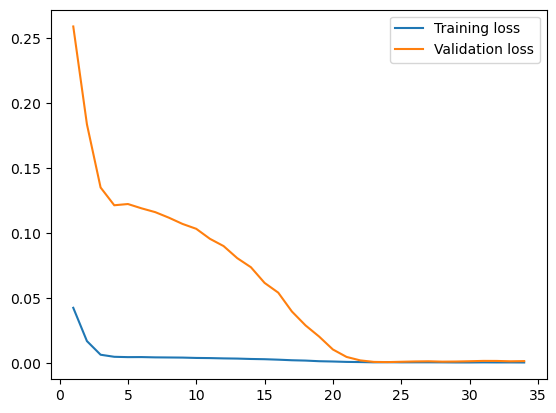

In [14]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

#### Evaluation on test data

RMSE promedio: 15.452756     std: 0.0


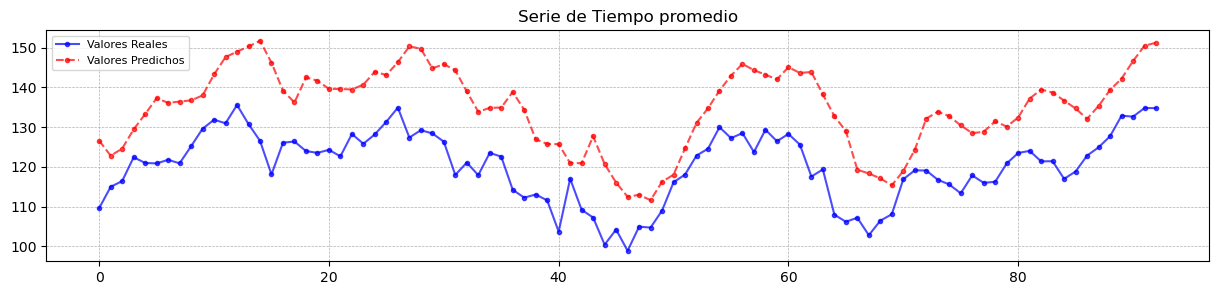

In [15]:
y_predicted = []
y_observed = []

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)

        # y_predicted.extend(y_pred.cpu().numpy())
        y_predicted.append(y_pred.cpu().numpy())
        y_observed.append(y_batch.cpu().numpy())

predicted = np.concatenate(y_predicted, axis=0)
observed = np.concatenate(y_observed, axis=0)

predicted = scaler.inverse_transform(predicted)
observed = scaler.inverse_transform(observed)

# Calculamos el RMSE por cada serie de tiempo
rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)

best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)


print("RMSE promedio:", np.mean(rmses), "    std:", np.std(rmses))

plt.figure(figsize=(15, 3))
plt.plot(np.mean(observed, axis=1), label='Valores Reales', marker='.', color='blue', alpha=0.7)
plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', marker='.', color="red", alpha=0.7)
plt.title(f'Serie de Tiempo promedio')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

#### All data

RMSE promedio:  5.3629813


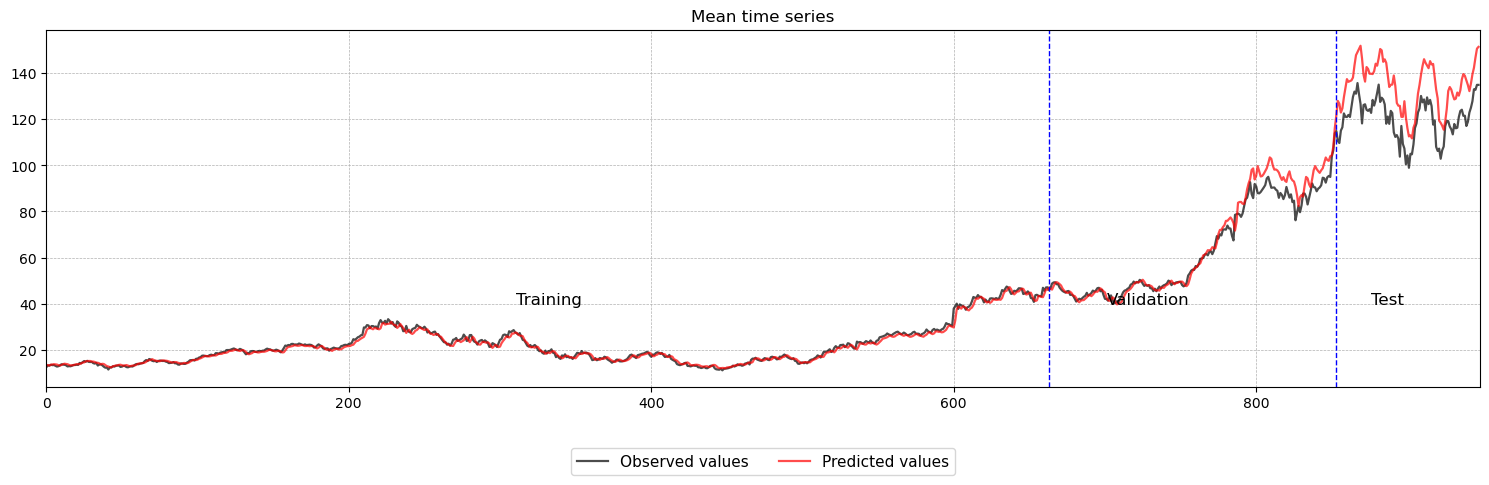

In [16]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted = scaler.inverse_transform(y_pred_test.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())

rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)
    
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print("RMSE promedio: ", np.mean(rmses))

plt.figure(figsize=(15, 5))
plt.plot(np.mean(observed, axis=1), color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain)-lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='blue', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title(f'Mean time series')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Predicting the price with multivariate LSTM model

### **Many to one**

In [17]:
df

,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


Now, our prediction consist of all the orhers columns except our target (Close in our case).

In [18]:
X, y = df.drop(columns=['Close', 'Volume']), df.Close.values
# X, y = df, df.Close.values
X.shape, y.shape

((950, 3), (950,))

In [19]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [20]:
total_rows = X_trans.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

# variables
XTrain = X_trans[:train_end]
XValidation = X_trans[train_end:validation_end]
XTest = X_trans[validation_end:]

# target
TTrain = y_trans[:train_end]
TValidation = y_trans[train_end:validation_end]
TTest = y_trans[validation_end:]

In [21]:
def create_lookback_many_to_one(input_sequences, output_sequence, lookback, device):
    """
    Prepares the dataset for a many-to-one LSTM model, where each input sequence has 
    a corresponding single target value from a separate output sequence.
    
    Parameters:
        input_sequences (array-like): The input time series data.
        output_sequence (array-like): The target time series data.
        lookback (int): Number of previous time steps to consider for each prediction.
        device (str): The device on which tensors should be stored ('cpu' or 'cuda').
        
    Returns:
        X_tensor (torch.Tensor): Tensor of input sequences with shape (num_samples, lookback, num_features).
        y_tensor (torch.Tensor): Tensor of target values with shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(input_sequences) - lookback):
        # Extract a window of length `lookback` from `input_sequences`
        window = input_sequences[i:(i + lookback)]
        # Target is the single value from `output_sequence` after the window
        target_value = output_sequence[i + lookback]
        
        X.append(window)
        y.append(target_value)
    
    # Convert lists to tensors and move to specified device
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    return X_tensor, y_tensor


In [22]:
lookback = 50
XTrain_tensor, TTrain_tensor = create_lookback_many_to_one(XTrain, TTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback_many_to_one(XValidation, TValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback_many_to_one(XTest, TTest, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([615, 50, 3]), 
TTrain_tensor shape: torch.Size([615, 1])

XValidation_tensor shape: torch.Size([140, 50, 3]), 
TValidation_tensor shape: torch.Size([140, 1])

XTest_tensor shape: torch.Size([45, 50, 3]), 
TTest_tensor shape: torch.Size([45, 1])


In [23]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

39
5
2


In [24]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

Epoch [10/100] - Training Loss: 0.0002, Validation Loss: 0.0128, Learning Rate: 0.000500
Validation RMSE: 12.315935


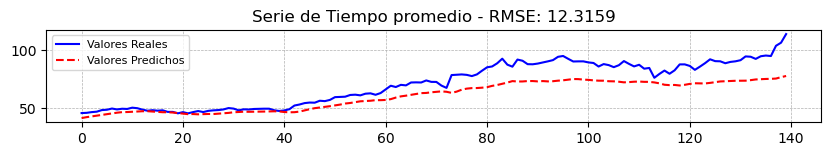


Epoch [20/100] - Training Loss: 0.0002, Validation Loss: 0.0044, Learning Rate: 0.000500
Validation RMSE: 6.9740644


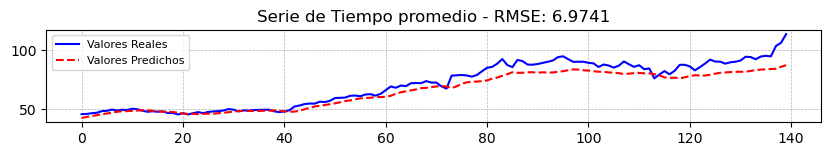


Epoch [30/100] - Training Loss: 0.0001, Validation Loss: 0.0053, Learning Rate: 0.000500
Validation RMSE: 7.718165


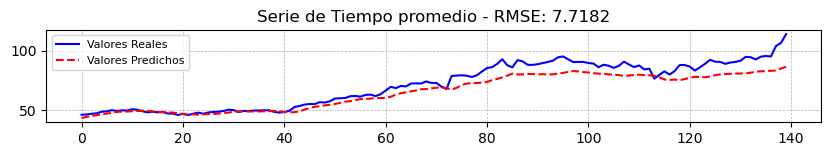


Epoch [40/100] - Training Loss: 0.0001, Validation Loss: 0.0042, Learning Rate: 0.000500
Validation RMSE: 6.933271


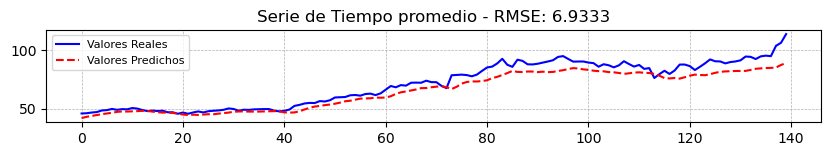


Epoch [50/100] - Training Loss: 0.0001, Validation Loss: 0.0030, Learning Rate: 0.000500
Validation RMSE: 5.618682


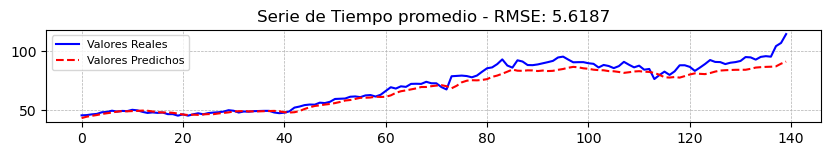


Early stopping! in epoch 59
Training Loss: 0.0001, Validation Loss: 0.0019, Learning Rate: 0.000500
Validation RMSE: 4.427396     std: 0.0


In [25]:
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn =  nn.MSELoss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 100
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  

for epoch in range(n_epochs):
    total_loss = 0.0  
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() 
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() 
        optimizer.step() 

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = []
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    # scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = scaler.inverse_transform(predicted)
    observed = scaler.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)

    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))

        break
    
    if (epoch+1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(10, 1.2))
        plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', color="red")
        plt.title(f'Serie de Tiempo promedio - RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()

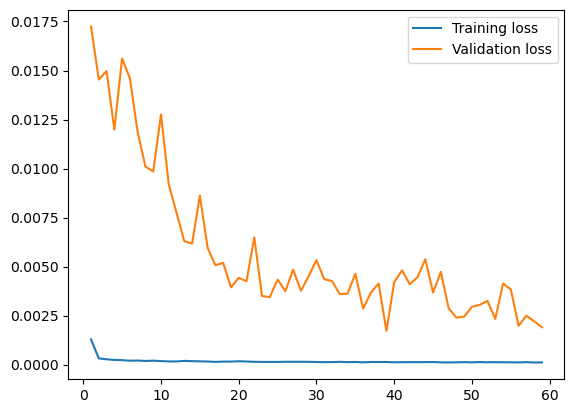

In [26]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

In [27]:
stop

NameError: name 'stop' is not defined

### **Many to one - multistep**

In [28]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() 

    for i in range(len(input_sequences)):

        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        if out_end_ix > len(input_sequences): break # this if check if we are beyond the dataset
        
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)

    return np.array(X), np.array(y)

In [50]:
Xtensor, Ttensor = split_sequences(X_trans, y_trans, 50, 10)
print(Xtensor.shape, Ttensor.shape)

(892, 50, 3) (892, 10)


In [51]:
assert Ttensor[0].all() == y_trans[9:14].squeeze(1).all()
Ttensor[0]

array([0.01659992, 0.017002  , 0.01202624, 0.01301737, 0.01575555,
       0.01482674, 0.01138693, 0.01052045, 0.0129651 , 0.01384164])

In [52]:
y_trans[9:14].squeeze(1)

array([0.01312795, 0.01446085, 0.01719902, 0.02123391, 0.01998745])

In [54]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = Xtensor[:-50]
X_test = Xtensor[-50:]

y_train = Ttensor[:-50]
y_test = Ttensor[-50:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 


Training Shape: (842, 50, 3) (842, 10)
Testing Shape: (50, 50, 3) (50, 10)


In [55]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [34]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 50, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 50, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 


Training Shape: torch.Size([922, 10, 3]) torch.Size([922, 5])
Testing Shape: torch.Size([15, 10, 3]) torch.Size([15, 5])


In [35]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 10, 5)
X_check[-1][0:4]

array([[116.51999664, 115.37999725, 121.80000305],
       [122.01999664, 121.61000061, 124.94000244],
       [126.80000305, 121.80000305, 127.66999817],
       [123.97000122, 119.26000214, 124.02999878]])

In [36]:
y_check[-1]

array([127.72000122, 132.88999939, 132.6499939 , 134.80999756,
       134.80000305])

In [37]:
df.Close.values[-5:]

array([127.72000122, 132.88999939, 132.6499939 , 134.80999756,
       134.80000305])

In [38]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        
        return out

In [39]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        print(outputs.shape)
        print(y_train.shape)
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

In [44]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 3 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 5 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [45]:
print(lstm)

LSTM(
  (lstm): LSTM(3, 2, batch_first=True, dropout=0.2)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
)


In [46]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

torch.Size([922, 5])
torch.Size([922, 5])
Epoch: 0, train loss: 0.18022, test loss: 0.92235
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch.Size([922, 5])
torch

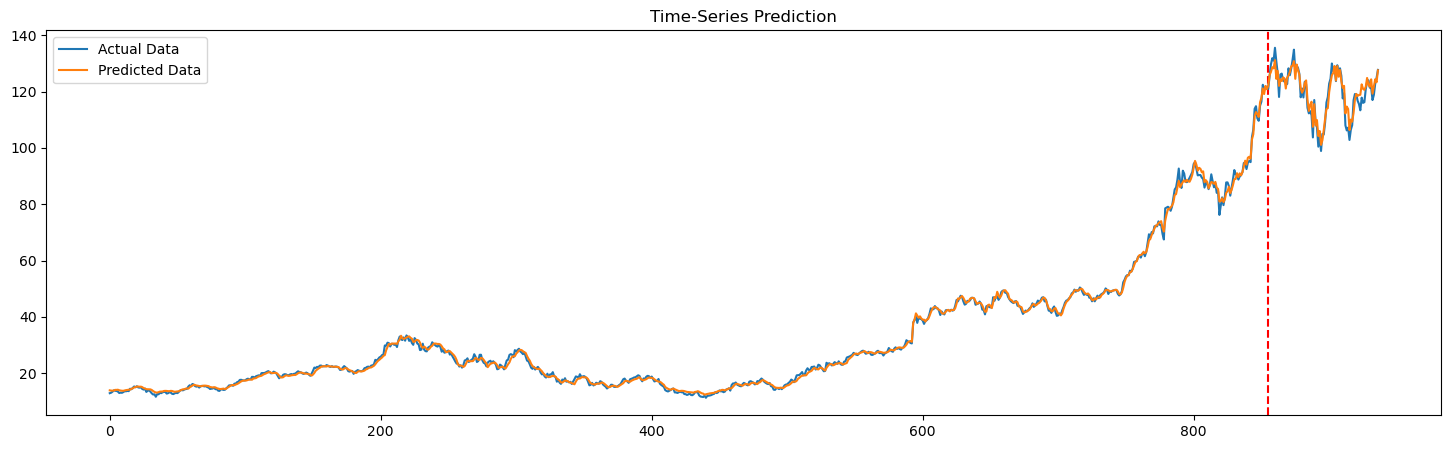

In [48]:
df_X_ss = ss.transform(df.drop(columns=['Close', 'Volume'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 10, 5)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 10, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(18,5)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show() 

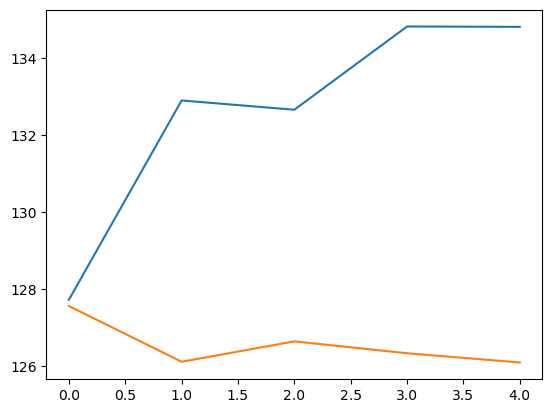

In [49]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
# plt.savefig("small_plot.png", dpi=300)
plt.show()